In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
from datetime import datetime,timedelta
import numpy as np

### SAX library
from saxpy.sax import sax_via_window
from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.sax import ts_to_string
from saxpy.hotsax import find_discords_hotsax


### Load datasets
#### df: train dataset
#### df_validation: validation dataset

In [2]:
def parser(x):
    return pd.datetime.strptime(x,'%d/%m/%y %H')
 
idx_change = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
        'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4',
        'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
        'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
        'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
        'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422', 'ATT_FLAG']

#train
df = pd.read_csv('BATADAL_dataset_train.csv',index_col=0,header=0,parse_dates=[0],date_parser=parser)
del df.index.name

#validation
df_validation = pd.read_csv("BATADAL_dataset_optimize.csv",index_col=0,header=0,parse_dates=[0],date_parser=parser)
del df_validation.index.name

df_validation.columns = idx_change
df_validation.head()

L_T1 = df['L_T1']
L_T1_validation = df_validation['L_T1']

#load as sequence array
L_T1_np = np.array(L_T1).T
L_T1_validation_np = np.array(L_T1_validation).T

#lenth : 8761
len(L_T1_np)


8761

### Assign attacks to corresponding sensor

In [3]:
#All attacked data
attacked = L_T1_validation.loc[df_validation['ATT_FLAG']==1]

Attacked_date = []
for date in attacked.index:
    Attacked_date.append(str(date).split(' ')[0])
Attacked_date = list(set(Attacked_date))


LT1_attacked = [Attacked_date[i] for i in [0,9,12,3,8,7]]
print("Dates that L_T1 got attacked:\n",LT1_attacked)
LT4_attacked = [Attacked_date[i] for i in [10,4,5,6,11]]
print("Dates that L_T4 got attacked:\n",LT4_attacked)
LT7_attacked = [Attacked_date[i] for i in [1,2]]
print("Dates that L_T7 got attacked:\n",LT7_attacked)

Dates that L_T1 got attacked:
 ['2016-10-10', '2016-12-07', '2016-10-31', '2016-10-11', '2016-11-27', '2016-12-09']
Dates that L_T4 got attacked:
 ['2016-12-06', '2016-12-08', '2016-09-14', '2016-11-01', '2016-10-30']
Dates that L_T7 got attacked:
 ['2016-10-09', '2016-09-15']


### plot the result after normalization

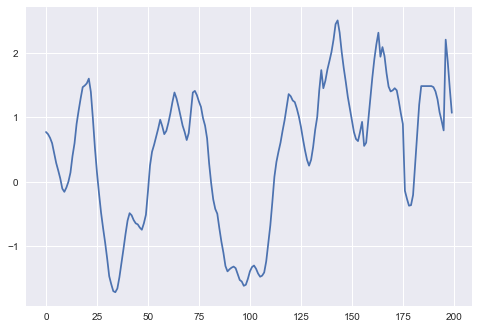

In [4]:
plt.clf()
# dataset['L_T1'][0:60].plot()
plt.plot(znorm(L_T1_validation_np)[2200:2400])
# plt.plot(znorm(L_T1_np)[0:192])
plt.show()

## Implement SAX method
### saxpy : https://github.com/seninp/saxpy
### PAA:  https://jmotif.github.io/sax-vsm_site/morea/algorithm/PAA.html
### sax paper: http://crpit.com/confpapers/CRPITV134Sun.pdf



### LT_1 Sensor

In [6]:
L_T = df['L_T1']
L_T_validation = df_validation['L_T1']
#load as sequence array
L_T_np = np.array(L_T).T
L_T_validation_np = np.array(L_T_validation).T

#znorm dataset
LT_znorm = znorm(L_T_np)
count = 0

#sax by window()        PAA: Piecewise Aggregate Approximation
#parameters: (data, window size, PAA agregation , alphabet_size , numerosity reduction strategy, z-normalization threshold)
sax_train = sax_via_window(LT_znorm, 120, 8, 2, "exact", 0.01)
print("train done")

# L_T1_validation
LT_znorm = znorm(L_T_validation_np)

sax_validation = sax_via_window(LT_znorm, 120, 8, 2, "exact", 0.01)
print("validation done")


# match to find anomalies
Attack_detected = []
for i in list(sax_validation.keys()):
    if i not in list(sax_train.keys()):
        print("pattern %s is anomaly"%i)
        for ind in sax_validation[i]:
            Attack_detected.append(str(L_T_validation.index[ind]).split(' ')[0]) # get date of detected anomalies
Attack_detected = list(set(Attack_detected))

TP,FN,FP = 0,0,0
print("\nAttacks happend on L_T1 sensor(by date):\n",LT1_attacked)
print("\nAttacks detected on L_T1 sensor:\n",Attack_detected)
for ind in LT1_attacked:
    if ind in Attack_detected:
        TP += 1
    else:
        FN += 1
for ind in Attack_detected:
    if ind not in LT1_attacked:
        FP += 1
        
print("\nTP:%d, FN: %d, FP: %d"%(TP,FN,FP))



train done
validation done
pattern abaabbbb is anomaly
pattern aabaaabb is anomaly
pattern babbaaaa is anomaly
pattern bbbaaabb is anomaly
pattern abaaabbb is anomaly
pattern bbaabbbb is anomaly
pattern baaabbbb is anomaly
pattern aabbbbbb is anomaly
pattern bbbbbbaa is anomaly
pattern bbbbbaaa is anomaly
pattern bbbbbaab is anomaly
pattern bbbbaaab is anomaly
pattern bbabaaab is anomaly
pattern bbbbaaba is anomaly
pattern bbbaabaa is anomaly
pattern aabaaaab is anomaly
pattern aaabbaba is anomaly
pattern abbababa is anomaly
pattern abaababa is anomaly
pattern ababbaba is anomaly
pattern abbabbbb is anomaly

Attacks happend on L_T1 sensor(by date):
 ['2016-10-10', '2016-12-07', '2016-10-31', '2016-10-11', '2016-11-27', '2016-12-09']

Attacks detected on L_T1 sensor:
 ['2016-12-10', '2016-10-06', '2016-10-11', '2016-10-09', '2016-10-10', '2016-09-03', '2016-11-30', '2016-10-04', '2016-10-08', '2016-10-21', '2016-10-23', '2016-12-16', '2016-12-06', '2016-12-11', '2016-08-19', '2016-10-30

### L_T1 performance on each different parameters


LT1 :      TP FN FP
12,8,2     0  6  9
12,8,3     2  4  44
24,7,3     2  4  25
24,6,3     1  5   8
24,8,3     4  2  44
24,8,2     2  4   9
24,10,2    1  5  21
24,10,3    4  2  80
48,8,3     0  6  32
100, 8,2   2  4  16
110, 8,2   0  6  17
120, 8,2   3  3  17
140, 8,2   1  5  15
120, 8,3   5  1  89
120, 7,3   2  4  59
120, 6,3   3  3  18
110, 6,3   2  4  31
120, 5,3   0  6  12
120, 5,4   1  5  23
100, 6,3   2  4  26



### LT_4 Sensor

In [8]:

L_T = df['L_T4']
L_T_validation = df_validation['L_T4']

L_T_np = np.array(L_T).T
L_T_validation_np = np.array(L_T_validation).T

#znorm dataset
LT_znorm = znorm(L_T_np)
count = 0
                                  
sax_train = sax_via_window(LT_znorm, 50, 7, 3, "exact", 0.01)
print("train done")

# L_T4_validation
LT_znorm = znorm(L_T_validation_np)

sax_validation = sax_via_window(LT_znorm, 50, 7, 3, "exact", 0.01)

print("validation done")


# match to find anomalies
Attack_detected = []
for i in list(sax_validation.keys()):
    if i not in list(sax_train.keys()):
#         print("%s is anomaly"%i)
        for ind in sax_validation[i]:
            Attack_detected.append(str(L_T_validation.index[ind]).split(' ')[0]) # get date of detected anomalies
Attack_detected = list(set(Attack_detected))

TP,FN,FP = 0,0,0
print("\nAttacks happend on L_T4 sensor(by date):\n",LT4_attacked)
print("\nAttacks detected on L_T4 sensor:\n",Attack_detected)
for ind in LT4_attacked:
    if ind in Attack_detected:
        TP += 1
    else:
        FN += 1
for ind in Attack_detected:
    if ind not in LT4_attacked:
        FP += 1
        
print("TP:%d, FN: %d, FP: %d"%(TP,FN,FP))




train done
validation done

Attacks happend on L_T4 sensor(by date):
 ['2016-12-06', '2016-12-08', '2016-09-14', '2016-11-01', '2016-10-30']

Attacks detected on L_T4 sensor:
 ['2016-09-10', '2016-10-10', '2016-09-15', '2016-12-17', '2016-07-20', '2016-11-12', '2016-08-13', '2016-11-09', '2016-10-12', '2016-09-12', '2016-12-21', '2016-09-24', '2016-11-15', '2016-10-02', '2016-11-24', '2016-08-24', '2016-08-12', '2016-11-01', '2016-12-03', '2016-11-13', '2016-11-25', '2016-11-27', '2016-12-22', '2016-12-11', '2016-09-06', '2016-11-26', '2016-07-04', '2016-12-18', '2016-10-31', '2016-11-21', '2016-07-09', '2016-11-23', '2016-11-14', '2016-09-20', '2016-07-08', '2016-09-03', '2016-09-18', '2016-10-04', '2016-11-28', '2016-11-16', '2016-09-29', '2016-07-11', '2016-11-08', '2016-09-11', '2016-10-18', '2016-09-07', '2016-10-27', '2016-10-03', '2016-10-06', '2016-11-17', '2016-11-05', '2016-10-16', '2016-12-08', '2016-10-13', '2016-10-07', '2016-10-14', '2016-12-06', '2016-08-21', '2016-10-30

### L_T4 performance on each different parameters

LT4:      TP FN FP
20,6,3     2 3  25
50,7,3     4 1  58
60,7,3     3 2  67
100,7,3    2 3  49

20,7,3     2 3  78
20,8,3     5 0  136
120,8,2    0 5  3
100,8,2    0 5  4
120,20,2   5 0  165
50,4,2     0 5  0
50,8,2     0 5  2
50,20,2    5 0  167
200,20,2    5 0 161
300,10,2    3 2 52
300, 12, 2  5 0 147
500, 8, 2   0 5 4
300,15,2    5 0 157
500, 12, 2  4 1 143
500, 15, 2  4 1 150
500, 10, 2  3 2 59

300,20,2    5 0 157
25,8,2     0 5  6
120,8,3    4 1  68



### LT_7 Sensor

In [9]:
L_T = df['L_T7']
L_T_validation = df_validation['L_T7']
#load as sequence array
L_T_np = np.array(L_T).T
L_T_validation_np = np.array(L_T_validation).T

#znorm dataset
LT_znorm = znorm(L_T_np)
count = 0
#     print(count)
                                  
sax_train = sax_via_window(LT_znorm, 80,7, 3, "exact", 0.01)
print("train done")


# L_T7_validation
LT_znorm = znorm(L_T_validation_np)
sax_validation = sax_via_window(LT_znorm, 80, 7, 3, "exact", 0.01)
print("validation done")


# match to find anomalies
Attack_detected = []
for i in list(sax_validation.keys()):
    if i not in list(sax_train.keys()):
        print("%s is anomaly"%i)
        for ind in sax_validation[i]:
            Attack_detected.append(str(L_T_validation.index[ind]).split(' ')[0]) # get date of detected anomalies
Attack_detected = list(set(Attack_detected))

TP,FN,FP = 0,0,0
print("\nAttacks happend on L_T7 sensor(by date):\n",LT7_attacked)
print("\nAttacks detected on L_T7 sensor:\n",Attack_detected)
for ind in LT7_attacked:
    if ind in Attack_detected:
        TP += 1
    else:
        FN += 1
for ind in Attack_detected:
    if ind not in LT7_attacked:
        FP += 1
        
print("\nTP:%d, FN: %d, FP: %d"%(TP,FN,FP))





train done
validation done
bbabbca is anomaly
bacbcac is anomaly
abbccab is anomaly
bbcabaa is anomaly
cabaacb is anomaly
bcabcca is anomaly
abccbca is anomaly
bcbbcaa is anomaly
ccbcaba is anomaly
cbbcaab is anomaly
cbcabac is anomaly
bbcaabc is anomaly
bcabacc is anomaly
cbbabcc is anomaly
bcbcbaa is anomaly
cabacbc is anomaly
bbaabcc is anomaly
bbacbcc is anomaly
abacbcc is anomaly
aabccbb is anomaly
baabbcc is anomaly
abbbccb is anomaly
cabbacb is anomaly
abbacbc is anomaly
baacbbc is anomaly
bacbccb is anomaly
aacbbcb is anomaly
cbbcbaa is anomaly
bcbaacb is anomaly
ccaacbb is anomaly
cbbbcba is anomaly
bbaacbc is anomaly
aaabcbc is anomaly
baacbcb is anomaly
aacbcbb is anomaly
cbcbaaa is anomaly
cbcbaab is anomaly
bccaabb is anomaly
abbabbc is anomaly
acabacc is anomaly
cbbbcaa is anomaly
bbcaabb is anomaly
bcaabbb is anomaly
bbcabca is anomaly
bccbcaa is anomaly
bbbcaac is anomaly
cbcbaca is anomaly
cbcaaca is anomaly
cbcabca is anomaly
bcbacac is anomaly
bcabcab is anomaly
bbac

### L_T7 performance on each different parameters

L_T7
20, 5, 3 :  0 2 10
20, 8, 3 :  2 0 141
20, 8, 2 :  0 2 2
200, 8, 3 :  1 1 51
100, 8, 3 :  2 0 78
100, 8, 2 :  0 2 3
100, 7, 3 :  1 1 39
90, 7, 3 :  1 1 33
#################### 80, 7, 3 :  2 0 53
#################### 80, 10, 2 :  1 1 20
70, 7, 3 :  1 1 45
50, 8, 3 :  1 1 45
50, 7, 3 :  0 2 60
80, 7, 3 :  2 0 53
#################### 80, 15, 2:  2 0 53